In [2]:
import pymongo
import pandas as pd
import matplotlib as plt
from pandas import Series,DataFrame
pd.set_option('display.width', None)  # 设置字符显示宽度
pd.set_option('display.max_rows', None)  # 设置显示最大行
pd.set_option('display.max_columns', None)  # 设置显示最大行
#二行即可搞定画图中文乱码
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#连接数据库
client = pymongo.MongoClient('localhost',27017)
futures = client.futures


market = futures.market
unit = futures.unit
position = futures.position
#加载数据
market = DataFrame(list(market.find()))
unit = DataFrame(list(unit.find()))
position = DataFrame(list(position.find()))


# #类型转换
# market['set_close'] = market['set_close'].astype(float)
# unit['unit'] = unit['unit'].astype(float)

#大写字母
position['variety']=position['variety'].str.upper()

#删除/选取某行含有特殊数值的列
position=position.set_index('名次')

#选择需要显示的字段
data1=market[['date','variety','set_close']]

data2=unit[[ 'variety','unit']]
position=position[['date','variety','symbol','持买仓量期货公司','持买仓量', '持买仓量增减','持卖仓量期货公司','持卖仓量', '持卖仓量增减']]
# print(position.head())

#查询会员
members='永安期货'
data3=position[(position['持买仓量期货公司'] == members)]
#汇总合约
data3=data3[['date','variety','持买仓量期货公司','持买仓量']]
data3=data3.groupby(['date','variety','持买仓量期货公司'])[['持买仓量']].sum()
data4=position[(position['持卖仓量期货公司'] == members)]
# print(data4.head())
data4=data4[['date','variety','持卖仓量期货公司','持卖仓量']]
data4=data4.groupby(['date','variety','持卖仓量期货公司'])[['持卖仓量']].sum()
print(data3.head())
print(data4.head())
#并集
data5=pd.merge(data3,data4, on=['date','variety'],how='outer')
data5['会员简称']=data5.apply(lambda x: members,axis=1)

#nan缺失值填充fillna()为0
data5=data5.fillna(0)
data5['净持仓']=data5.apply(lambda x: x['持买仓量']-x['持卖仓量'],axis=1)
#选择需要显示的字段
data5=data5[['会员简称','持买仓量','持卖仓量','净持仓']]
data5=data5.reset_index(['variety','date'])
print(data5.head())
netpostion=data5.set_index('date')
# netpostion.date = pd.to_datetime(netpostion.date)
# df.pivot(index='Date', columns='val', values='count').plot(marker='o')
netpostion=data5.pivot_table('净持仓',index='date',columns='variety',fill_value=0)
# netpostion=netpostion[['RB','HC','J','JM','I']]
# netpostion['合计']=netpostion.sum(axis=1)
# netpostion.plot(figsize=(18,5))
# print(netpostion)

#合约价值
contractValue=pd.merge(data1,data2,how='left',sort=False).drop_duplicates()
contractValue['contractValue'] = contractValue.apply(lambda x: x['set_close']*x['unit'],axis=1)
contractValue=contractValue[['date','variety','contractValue']]
#值替换replace()
contractValue=contractValue.replace(['TA'],'PTA')
print(contractValue.head())
# contractValue.set_index(['date','variety'], inplace = True)
sz=pd.merge(data5,contractValue,on=['date','variety'],how='left')
#净持仓价值

sz['净持仓价值']=sz.apply(lambda x: x['净持仓']*x['contractValue'],axis=1)
sz=sz[['date','variety','会员简称','净持仓价值']]
# sz=sz[(sz['variety']=='M')]
# sz=sz[sz['date']=='2018-10-23']
# sz=sz[sz['date']=='2018-10-23']
# sz=sz[(sz['variety']=='M')]
sz=sz.sort_values(by='净持仓价值')
sz=sz.pivot_table('净持仓价值',index=['date','会员简称'],columns='variety',fill_value=0)
sz=sz.copy()
sz['化工板块']=sz[['RU','MA','V','L','PP','BU','PTA']].sum(axis=1)
sz['油脂板块']=sz[['Y','P','OI']].sum(axis=1)
sz['有色板块']=sz[['CU','AL','ZN','NI','PB']].sum(axis=1)
sz['黑色板块']=sz[['RB','HC','ZC','J','JM','I']].sum(axis=1)
sz['黄金白银']=sz[['AU','AG']].sum(axis=1)
sz['工业品']=sz[['CU','AL','ZN','NI','PB','RB','FG','RU','L','V','PTA','MA','PP','JM','J','ZC','I','BU','HC','SM','SF','FU']].sum(axis=1)
sz['农产品']=sz[['A','C','M','RM','Y','P','OI','CF','SR','JD','CS','AP']].sum(axis=1)
sz['商品板块']=sz.sum(axis=1)
sz
# print(sz)
# print(sz['净持仓价值'].sum())
# sz.plot.bar(x='variety',y='净持仓价值',figsize=(15,5),label=members,title='净持仓价值排名'+' 日期：')
# +sz['date'].loc[1]


# long=sz[sz['净持仓价值']>1e+08]
# short=sz[sz['净持仓价值']<-1e+08]
# long.plot.bar(x='variety',y='净持仓价值',figsize=(10,5),label=members,title='净多持仓价值排名'+' 日期：')
# short.plot.bar(x='variety',y='净持仓价值',figsize=(10,5),label=members,title='净空持仓价值排名'+' 日期：')


# sz=sz.set_index(['date','variety'])
# print(sz.rank(method="max",ascending=True))
# sz=sz.set_index('date')
# print(sz)
# sz.plot.line(figsize=(15,5),label=members,title='净持仓价值排名'+' 日期：')

# sz=sz['date'].set_index()

# sz.pivot_table('净持仓价值',index='date',columns='variety')
# af.pivot_table('score',index='name',columns='course',aggfunc='mean',margins=True,fill_value=0)


# print(sz.head())
# # sz=sz[['RB','HC','J','JM','I']]

# # sz=sz[['RU','MA','V','L','PP','BU','PTA']]
# sz['合计']=sz.sum(axis=1)
# print(sz)
# sz.plot(figsize=(20,5))

                                持买仓量
date       variety 持买仓量期货公司         
2018-10-08 A       永安期货       6153.0
           AG      永安期货       9855.0
           AL      永安期货      17122.0
           AP      永安期货       5755.0
           AU      永安期货       3448.0
                                持卖仓量
date       variety 持卖仓量期货公司         
2018-10-08 A       永安期货       6068.0
           AG      永安期货      15811.0
           AL      永安期货       8723.0
           AP      永安期货       7546.0
           AU      永安期货        586.0
         date variety  会员简称     持买仓量     持卖仓量     净持仓
0  2018-10-08       A  永安期货   6153.0   6068.0    85.0
1  2018-10-08      AG  永安期货   9855.0  15811.0 -5956.0
2  2018-10-08      AL  永安期货  17122.0   8723.0  8399.0
3  2018-10-08      AP  永安期货   5755.0   7546.0 -1791.0
4  2018-10-08      AU  永安期货   3448.0    586.0  2862.0
         date variety  contractValue
0  2018-10-08      AG        52965.0
1  2018-10-08      AL        72395.0
2  2018-10-08      AP       117160.0
3  2018-10

,variety,A,AG,AL,AP,AU,B,BU,C,CF,CS,CU,CY,FG,FU,HC,I,J,JD,JM,JR,L,LR,M,MA,NI,OI,P,PB,PM,PP,PTA,RB,RI,RM,RU,SF,SM,SN,SR,V,WH,Y,ZC,ZN,化工板块,油脂板块,有色板块,黑色板块,黄金白银,工业品,农产品,商品板块
date,会员简称,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-08,永安期货,3261450,-315459540,608045605,-209833560,769878000,-14976780,636642300,-1294318000,-666455310,37010540,1710831720,244880,70060800,-36427660,-1012884480,-1009626700,1697405000,80690720,480353760,-291700,-1243328760,1174360,8624827680,-501839020,-520227462,-82956000,-1418264640,185322150,0,1800619800,-589055610,-1215124960,-141540,-757137500,-337115550,-55707300,-31065015,10600056,575559140,-114983970,-37375520,3832023160,-724187100,1197556360,-349060810,2330802520,3181528373,-1784064480,454418460,995263908,8724407680,23686619455
2018-10-09,永安期货,-16511610,-229660605,547143285,-179601610,823028000,-13795640,846910080,-1257216950,-580523650,7115650,1477716200,739740,-37175800,107562000,-1041597070,-740595000,2134417200,90657600,249055800,-294900,-995280840,-269800,7873414010,-116997640,-488692146,-43238800,-1462732550,199175700,-467600,1937440470,-334422540,-1339665000,-142080,-646156980,-410841525,-24990560,-14279440,3827746,546633100,-241230000,-37661540,4168285830,-140432000,1184237280,685578005,2662314480,2919580319,-878816070,593367395,2757458454,8500124040,29042492438
2018-10-10,永安期货,22349680,-266520120,722003360,-199487840,771572000,-8114520,784514900,-1168031250,-668548375,-28750800,1459428285,491840,-48473800,-31464980,-1050433800,-676504000,3558718800,73495070,79677000,-177000,-1230998825,-1244760,8106986820,-187743040,-123576060,-9429540,-1497521190,432944400,0,1913072200,-147791000,-2189143710,-142380,-537213300,-482017250,-21661080,-27261000,-1323837,339208800,-110201580,-34247840,4231424100,-68695200,1133201460,538835405,2724473370,3624001445,-346380910,505051880,3687595080,8664482175,32210429083
2018-10-11,永安期货,-7459760,-222446775,276132480,-247899150,1180710000,-36152820,891174510,-1208266800,-515663040,-28876650,110974100,487900,-16546880,-64482120,-949357200,-917504000,2459132500,82550700,39967200,-528300,-1132760475,-376460,8436214640,-167681800,-572067920,-73782720,-1514598570,467251810,0,1705634960,-140960085,-583797060,0,-510925690,-462274540,-21161700,-38831460,-3235188,230427330,-58033885,-34330500,4446491100,-133920800,1064689885,635098685,2858109810,1346980355,-85479360,958263225,1755577520,9088211390,28284678392
2018-10-12,永安期货,-5411580,-252404520,233982540,-310396050,892983000,-39169920,904137220,-1332451000,-284160060,-22809980,-10136200,495300,-28216320,-63284320,-931815130,-891183600,3671096400,99086000,-6013740,-530460,-1148020825,3266400,7811581080,-82523400,-560181475,-105010360,-1659093920,563075475,0,1237838000,-326165760,-1003195020,189760,-555858180,-472830480,-22970250,5845105,3989115,100922500,33173070,-32639880,4644762800,-178515400,1150916140,145607825,2880658520,1377656480,660373510,640578480,2075012030,8381161250,27193400170
2018-10-15,永安期货,-8039040,-153635625,12688415,-407398710,928464000,-40654780,895935960,-1341152220,-325283840,-72996000,555641670,248210,32027400,-88029280,-940972120,-869907000,3237547500,84644840,-41653200,-529200,-1083370275,-1466100,6443388160,-4008960,-481224070,-71514960,-1710571660,632885370,0,1154693400,-332043055,-1222631040,189680,-496100160,-476186200,-66492180,24088440,-7198688,99440600,-45108510,-31787840,4449785040,-159835000,1170671360,109912360,2667698420,1890662745,2549140,774828375,1904718625,6644202050,23237122047
2018-10-16,永安期货,15799050,-76983330,-101046680,-429095680,665712000,-40687850,918940880,-1326074560,-578762535,-25869480,196974295,494540,56755400,-51242310,-1225533680,-823816500,2726067000,60896600,41799600,-352320,-1628307075,-2968900,6224463420,53462760,-1418777316,58527360,-1590995640,604041180,0,997166115,-823705700,-1106280680,139980,-503860500,-488030130,-127960860,-12715500,2511767,78755880,-291993740,-32155200,4091249260,-239112000,1091919440,-1262466890,2558780980,373110919,-626876260,58

In [99]:



sz

,variety,A,AG,AL,AP,AU,B,BU,C,CF,CS,CU,CY,FG,FU,HC,I,J,JD,JM,L,LR,M,MA,NI,OI,P,PB,PP,PTA,RB,RM,RS,RU,SF,SM,SN,SR,V,WH,Y,ZC,ZN,化工板块,油脂板块,有色板块,黑色板块,商品板块
date,会员简称,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-08,海通期货,134448480,905489640,-402878175,472389120,450844000,3549000,35965300,211394000,-170818530,0,-1555006440,-2326360,7609500,-119680980,-331421760,55339100,159372000,79936230,173912940,37234980,-11049660,1120262160,-22170660,-857560846,-333697200,71520800,-8120250,-208702200,-68116620,-1496198760,98058850,-219320,-304119425,108270100,-66461805,-171073126,40822340,0,-8830480,500780420,249677300,-267984640,-529908625,238604020,-3091550351,-1189319180,-6061735113
2018-10-09,海通期货,163468770,959537985,-480253215,403194470,614524000,1894220,125583480,239016800,-285894000,0,-1390213210,-2219220,3308700,-18673200,-263966650,133561600,42995800,82456400,136857000,34586940,-12518720,991415040,362358210,-1099504645,-43170600,145678550,0,-86449970,-67543100,-1010949600,143538900,-163260,-286829550,100703200,-106182580,-160765332,391775280,76058000,-8631840,648916920,275034500,-181905840,157764010,751424870,-3151876910,-686467350,-2358525147
2018-10-10,海通期货,175314870,964219260,-530185175,568091260,591476000,3772540,-2016650,253350000,-307502375,54195840,-1308592810,-1598480,-11809100,-216937000,-414865320,492803500,138820500,83742570,204300000,235388405,-12664080,1480071420,209355480,-1233106475,208816480,106817480,-54843250,-91888760,-4402125,-696043530,187387900,0,-297532950,99634220,-121122720,-160037184,299805240,103941690,-8574720,715205580,245499800,46109420,152845090,1030839540,-3080618290,-29485050,67978041
2018-10-11,海通期货,184134280,905815500,-538838400,484780560,578880000,2897880,-69359490,305634940,-357367200,0,-1316477020,-3293325,-1434240,-147188960,-404820240,605593600,222977700,21192120,121867200,364585725,-12476960,1506895880,-8652800,-925182240,87785280,111981420,-75780340,76103490,34044030,173959730,173411960,-164610,-358320690,111350850,-118159180,-175582476,273749490,0,-8544480,439581750,216398800,23915570,38400265,639348450,-2832362430,935976790,1287258179
2018-10-12,海通期货,108960820,927682380,-516881540,571339170,294567000,30548280,7478420,272042000,-168814240,-9547810,-1210008875,-4953000,-267200,-106222240,-447908950,665433600,677013300,10300000,139304580,246014685,-13065600,241440200,370589260,-1022581980,137932160,116982440,-59222400,89717250,100634250,267616760,198326420,-163470,-329944860,118458430,-148474200,-164587930,244309100,7226150,-8608320,728181040,229181400,358404280,491715155,983095640,-2450290515,1530640690,3503591730
2018-10-15,海通期货,193581600,916773000,-553186540,381746430,470580000,29794700,-10044460,297328600,-315833455,-9456300,-1026751115,-4840095,-24962920,-99740880,-479222190,291261000,205177500,81742010,117276000,234148535,-12760500,230202800,358594560,-641249341,196394220,296424260,-16170310,-39608520,61896335,810656640,188120070,0,-331813200,105296230,-228712050,-186872064,233118200,10294335,-8655360,727530720,244075000,53202195,283467585,1220349200,-2184155111,1189223950,3254221264
2018-10-16,海通期货,168878520,939110970,-241927700,452241920,433044000,2156350,-33396660,334194880,-334375210,-8552090,-843961020,-3832685,-5733400,-116108160,-256406540,540456200,372525800,-42001970,164083920,-27861570,-13117140,290265500,-8016060,-601150770,110212980,316661280,-14062630,-297312510,-43735300,746008680,204427080,0,-328143550,100966470,-201761250,-160309835,243390000,0,-8727840,715507590,285294400,95121440,-738465650,1142381850,-1605980680,1851962460,3573952070
2018-10-17,海通期货,187206000,937889145,-235036935,571811400,409200000,4390840,2791500,236575680,-347274885,-8666840,-722188800,-1612650,-10047200,-133973400,-361002870,419446000,580563000,34712640,137563200,-77008110,-13072840,468031830,-31178940,-461707533,175369440,345713640,-20601600,-304105590,9160510,504790380,124943720,0,-351637000,89504640,-203362060,-164233940,300732240,0,-8700480,548472090,269435700,94754205,-751977630,106955517

In [3]:
chemical=sz.copy()
chemical=chemical[['RU','MA','V','L','PP','BU','PTA','商品板块','化工板块']]
chemical['max']=chemical[['RU','MA','V','L','PP','BU','PTA']].max(axis=1)
chemical['min']=chemical[['RU','MA','V','L','PP','BU']].min(axis=1)
chemical

# sz.plot(figsize=(20,5))

,variety,RU,MA,V,L,PP,BU,PTA,商品板块,化工板块,max,min
date,会员简称,,,,,,,,,,,
2018-10-08,永安期货,-337115550,-501839020,-114983970,-1243328760,1800619800,636642300,-589055610,23686619455,-349060810,1800619800,-1243328760
2018-10-09,永安期货,-410841525,-116997640,-241230000,-995280840,1937440470,846910080,-334422540,29042492438,685578005,1937440470,-995280840
2018-10-10,永安期货,-482017250,-187743040,-110201580,-1230998825,1913072200,784514900,-147791000,32210429083,538835405,1913072200,-1230998825
2018-10-11,永安期货,-462274540,-167681800,-58033885,-1132760475,1705634960,891174510,-140960085,28284678392,635098685,1705634960,-1132760475
2018-10-12,永安期货,-472830480,-82523400,33173070,-1148020825,1237838000,904137220,-326165760,27193400170,145607825,1237838000,-1148020825
2018-10-15,永安期货,-476186200,-4008960,-45108510,-1083370275,1154693400,895935960,-332043055,23237122047,109912360,1154693400,-1083370275
2018-10-16,永安期货,-488030130,53462760,-291993740,-1628307075,997166115,918940880,-823705700,10994263454,-1262466890,997166115,-1628307075
2018-10-17,永安期货,-505693350,230278260,-376187500,-1477236375,1077053315,959047740,-1013318305,9519009777,-1106056215,1077053315,-1477236375
2018-10-18,永安期货,-497023120,349181800,-443329485,-1086879805,1011279000,666707560,-979962060,-5598760213,-980026110,1011279000,-1086879805


In [107]:
oil=sz.copy()
oil=oil[['Y','P','OI','油脂板块']]
oil['2018-10-21':]

,variety,Y,P,OI,油脂板块
date,会员简称,,,,
2018-10-22,海通期货,0,320223780,91488940,411712720
2018-10-23,海通期货,-315275850,310126050,-10177920,-15327720
2018-10-24,海通期货,-340102000,244855530,-357413800,-452660270
2018-10-25,海通期货,-389150720,243949440,-343868700,-489069980
2018-10-26,海通期货,-383878990,252194540,-332046000,-463730450
2018-10-29,海通期货,-335013300,338415840,-308148480,-304745940
2018-10-30,海通期货,-399665750,313098540,-304161150,-390728360


In [90]:
有色=sz.copy()
有色=有色[['CU','AL','ZN','NI','PB']]
有色['有色板块']=有色.sum(axis=1)
有色.reset_index('date')
有色

,variety,CU,AL,ZN,NI,PB,有色板块
date,会员简称,,,,,,
2018-10-08,海通期货,-1555006440,-402878175,-267984640,-857560846,-8120250,-3091550351
2018-10-09,海通期货,-1390213210,-480253215,-181905840,-1099504645,0,-3151876910
2018-10-10,海通期货,-1308592810,-530185175,46109420,-1233106475,-54843250,-3080618290
2018-10-11,海通期货,-1316477020,-538838400,23915570,-925182240,-75780340,-2832362430
2018-10-12,海通期货,-1210008875,-516881540,358404280,-1022581980,-59222400,-2450290515
2018-10-15,海通期货,-1026751115,-553186540,53202195,-641249341,-16170310,-2184155111
2018-10-16,海通期货,-843961020,-241927700,95121440,-601150770,-14062630,-1605980680
2018-10-17,海通期货,-722188800,-235036935,94754205,-461707533,-20601600,-1344780663
2018-10-18,海通期货,-699402070,-274695900,517954950,-791399640,-17390835,-1264933495


In [126]:
黑色板块=sz.copy()
黑色板块=黑色板块[['RB','HC','ZC','J','JM','I','黑色板块']]
黑色板块['max']=黑色板块[['RB','HC','ZC','J','JM','I']].max(axis=1)
黑色板块['min']=黑色板块[['RB','HC','ZC','J','JM','I']].min(axis=1)
黑色板块.reset_index('date')
黑色板块

,variety,RB,HC,ZC,J,JM,I,黑色板块,max,min
date,会员简称,,,,,,,,,
2018-10-08,永安期货,-1215124960,-1012884480,-724187100,1697405000,480353760,-1009626700,-1784064480,1697405000,-1215124960
2018-10-09,永安期货,-1339665000,-1041597070,-140432000,2134417200,249055800,-740595000,-878816070,2134417200,-1339665000
2018-10-10,永安期货,-2189143710,-1050433800,-68695200,3558718800,79677000,-676504000,-346380910,3558718800,-2189143710
2018-10-11,永安期货,-583797060,-949357200,-133920800,2459132500,39967200,-917504000,-85479360,2459132500,-949357200
2018-10-12,永安期货,-1003195020,-931815130,-178515400,3671096400,-6013740,-891183600,660373510,3671096400,-1003195020
2018-10-15,永安期货,-1222631040,-940972120,-159835000,3237547500,-41653200,-869907000,2549140,3237547500,-1222631040
2018-10-16,永安期货,-1106280680,-1225533680,-239112000,2726067000,41799600,-823816500,-626876260,2726067000,-1225533680
2018-10-17,永安期货,-968994180,-1283284800,-307476000,2006996000,587243880,-693759500,-659274600,2006996000,-1283284800
2018-10-18,永安期货,-2450006460,-1479473820,-243734400,13937400,660686760,-1658949600,-5157540120,660686760,-2450006460


,variety,商品板块,工业品,农产品,黑色板块,有色板块,油脂板块,化工板块,黄金白银
date,会员简称,,,,,,,,
2018-10-08,永安期货,23686619455,995263908,8724407680,-1784064480,3181528373,2330802520,-349060810,454418460
2018-10-09,永安期货,29042492438,2757458454,8500124040,-878816070,2919580319,2662314480,685578005,593367395
2018-10-10,永安期货,32210429083,3687595080,8664482175,-346380910,3624001445,2724473370,538835405,505051880
2018-10-11,永安期货,28284678392,1755577520,9088211390,-85479360,1346980355,2858109810,635098685,958263225
2018-10-12,永安期货,27193400170,2075012030,8381161250,660373510,1377656480,2880658520,145607825,640578480
2018-10-15,永安期货,23237122047,1904718625,6644202050,2549140,1890662745,2667698420,109912360,774828375
2018-10-16,永安期货,10994263454,-1651395501,6075033175,-626876260,373110919,2558780980,-1262466890,588728670
2018-10-17,永安期货,9519009777,-2159121602,6011400850,-659274600,-232702992,2609577630,-1106056215,637956725
2018-10-18,永安期货,-5598760213,-6766018660,5441622660,-5157540120,-457504005,2577610640,-980026110,572413025


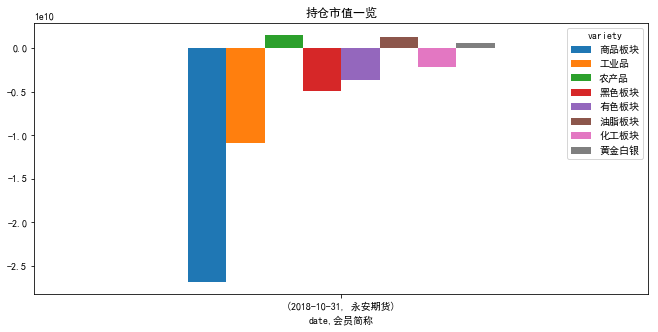

In [7]:
板块=sz.copy()
板块=板块[['商品板块','工业品','农产品','黑色板块','有色板块','油脂板块','化工板块','黄金白银']]
板块['2018-10-31':].plot.bar(rot=0,figsize=(11,5),title='持仓市值一览')
板块

,variety,CU,AL,ZN,NI,PB,RB,FG,RU,L,V,PTA,MA,PP,JM,J,ZC,I,BU,HC,SM,SF,FU,工业品,黑色板块,有色板块,化工板块,黄金白银,max,min
date,会员简称,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-08,永安期货,1710831720,608045605,1197556360,-520227462,185322150,-1215124960,70060800,-337115550,-1243328760,-114983970,-589055610,-501839020,1800619800,480353760,1697405000,-724187100,-1009626700,636642300,-1012884480,-31065015,-55707300,-36427660,995263908,-1784064480,3181528373,-349060810,454418460,1800619800,-1243328760
2018-10-09,永安期货,1477716200,547143285,1184237280,-488692146,199175700,-1339665000,-37175800,-410841525,-995280840,-241230000,-334422540,-116997640,1937440470,249055800,2134417200,-140432000,-740595000,846910080,-1041597070,-14279440,-24990560,107562000,2757458454,-878816070,2919580319,685578005,593367395,2134417200,-1339665000
2018-10-10,永安期货,1459428285,722003360,1133201460,-123576060,432944400,-2189143710,-48473800,-482017250,-1230998825,-110201580,-147791000,-187743040,1913072200,79677000,3558718800,-68695200,-676504000,784514900,-1050433800,-27261000,-21661080,-31464980,3687595080,-346380910,3624001445,538835405,505051880,3558718800,-2189143710
2018-10-11,永安期货,110974100,276132480,1064689885,-572067920,467251810,-583797060,-16546880,-462274540,-1132760475,-58033885,-140960085,-167681800,1705634960,39967200,2459132500,-133920800,-917504000,891174510,-949357200,-38831460,-21161700,-64482120,1755577520,-85479360,1346980355,635098685,958263225,2459132500,-1132760475
2018-10-12,永安期货,-10136200,233982540,1150916140,-560181475,563075475,-1003195020,-28216320,-472830480,-1148020825,33173070,-326165760,-82523400,1237838000,-6013740,3671096400,-178515400,-891183600,904137220,-931815130,5845105,-22970250,-63284320,2075012030,660373510,1377656480,145607825,640578480,3671096400,-1148020825
2018-10-15,永安期货,555641670,12688415,1170671360,-481224070,632885370,-1222631040,32027400,-476186200,-1083370275,-45108510,-332043055,-4008960,1154693400,-41653200,3237547500,-159835000,-869907000,895935960,-940972120,24088440,-66492180,-88029280,1904718625,2549140,1890662745,109912360,774828375,3237547500,-1222631040
2018-10-16,永安期货,196974295,-101046680,1091919440,-1418777316,604041180,-1106280680,56755400,-488030130,-1628307075,-291993740,-823705700,53462760,997166115,41799600,2726067000,-239112000,-823816500,918940880,-1225533680,-12715500,-127960860,-51242310,-1651395501,-626876260,373110919,-1262466890,588728670,2726067000,-1628307075
2018-10-17,永安期货,126383040,-50768550,1002713985,-1912375467,601344000,-968994180,12241720,-505693350,-1477236375,-376187500,-1013318305,230278260,1077053315,587243880,2006996000,-307476000,-693759500,959047740,-1283284800,-9459705,-118395810,-45474000,-2159121602,-659274600,-232702992,-1106056215,637956725,2006996000,-1912375467
2018-10-18,永安期货,198222245,-126809925,643307820,-1612147860,439923715,-2450006460,76609680,-497023120,-1086879805,-443329485,-979962060,349181800,1011279000,660686760,13937400,-243734400,-1658949600,666707560,-1479473820,-24981215,-163220200,-59356690,-6766018660,-5157540120,-457504005,-980026110,572413025,1011279000,-2450006460


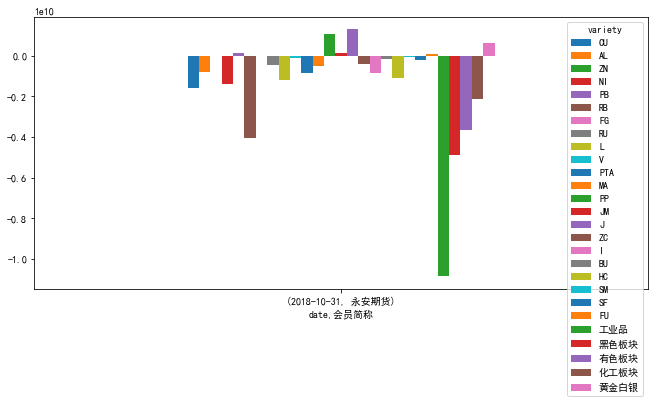

In [144]:
工业品=sz.copy()
工业品=工业品[['CU','AL','ZN','NI','PB','RB','FG','RU','L','V','PTA','MA','PP','JM','J','ZC','I','BU','HC','SM','SF','FU','工业品','黑色板块','有色板块','化工板块','黄金白银']]
工业品['2018-10-31':].plot.bar(rot=0,figsize=(11,5))
工业品['max']=工业品[['CU','AL','ZN','NI','PB','RB','FG','RU','L','V','PTA','MA','PP','JM','J','ZC','I','BU','HC','SM','SF','FU']].max(axis=1)
工业品['min']=工业品[['CU','AL','ZN','NI','PB','RB','FG','RU','L','V','PTA','MA','PP','JM','J','ZC','I','BU','HC','SM','SF','FU']].min(axis=1)
工业品
